In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Tensorflow-Models

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/.shortcut-targets-by-id/1oP3ewZgiatY88SU5esvVcTCqbdfjYu1d/Tensorflow-Models


In [4]:
!pip install -q --upgrade keras-cv

In [3]:
import os
import requests
from zipfile import ZipFile
import glob
from dataclasses import dataclass

import random
import numpy as np
import cv2

import tensorflow as tf
import keras_cv

import matplotlib.pyplot as plt

In [5]:
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:        tuple = (512, 512)
    BATCH_SIZE:          int = 8
    NUM_CLASSES:         int = 7  # 6 tools + background
    BRIGHTNESS_FACTOR: float = 0.4
    CONTRAST_FACTOR:   float = 0.4

In [6]:
@dataclass(frozen=True)
class TrainingConfig:
    MODEL:           str = "efficientnetv2_s_imagenet" # "resnet50_v2_imagenet"
    EPOCHS:          int = 10
    LEARNING_RATE: float = 1e-6 # 1e-5 # 1e-4
    CKPT_DIR:        str = "deeplabv3_plus_SIS_tuned_more.weights.h5" # "deeplabv3_plus_SIS.weights.h5"
    # CKPT_DIR:        str = os.path.join("checkpoints_"+"_".join(MODEL.split("_")[:2]),
    #                                     "deeplabv3_plus_"+"_".join(MODEL.split("_")[:2])+".h5")
    # LOGS_DIR:        str = "logs_"+"_".join(MODEL.split("_")[:2])

In [10]:
def build_pairs(image_dir, mask_dir):
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))
    mask_paths  = glob.glob(os.path.join(mask_dir, "*.png"))

    image_map = {
        os.path.splitext(os.path.basename(p))[0]: p
        for p in image_paths
    }
    mask_map = {
        os.path.splitext(os.path.basename(p))[0]: p
        for p in mask_paths
    }

    common_keys = sorted(image_map.keys() & mask_map.keys())

    images = [image_map[k] for k in common_keys]
    masks  = [mask_map[k]  for k in common_keys]

    print(f"Matched pairs: {len(images)}")
    print(f"Dropped images: {len(image_map) - len(images)}")
    print(f"Dropped masks : {len(mask_map) - len(masks)}")

    return images, masks

In [11]:
train_images = sorted(
    glob.glob("datasets/surgical_instruments/images/train/*.jpg")
)

train_masks = sorted(
    glob.glob("datasets/surgical_instruments/semantic_masks/train/*.png")
)

print(len(train_images), len(train_masks))

2855 2696


In [12]:
train_images, train_masks = build_pairs(
    "/content/gdrive/MyDrive/Tensorflow-Models/datasets/surgical_instruments/images/train",
    "/content/gdrive/MyDrive/Tensorflow-Models/datasets/surgical_instruments/semantic_masks/train",
)

valid_images, valid_masks = build_pairs(
    "/content/gdrive/MyDrive/Tensorflow-Models/datasets/surgical_instruments/images/valid",
    "/content/gdrive/MyDrive/Tensorflow-Models/datasets/surgical_instruments/semantic_masks/valid",
)

Matched pairs: 2696
Dropped images: 159
Dropped masks : 0
Matched pairs: 815
Dropped images: 26
Dropped masks : 0


In [13]:
train_data = tf.data.Dataset.from_tensor_slices(
    (train_images, train_masks)
)

valid_data = tf.data.Dataset.from_tensor_slices(
    (valid_images, valid_masks)
)

In [14]:
def read_image_mask(image_path, mask=False, size=DatasetConfig.IMAGE_SIZE):
    image = tf.io.read_file(image_path)

    if mask:
        # decode as single-channel label map
        image = tf.io.decode_png(image, channels=1)
        image.set_shape([None, None, 1])

        # resize WITHOUT interpolation artifacts
        image = tf.image.resize(
            image,
            size=size,
            method="nearest"   # <-- CRITICAL
        )

        image = tf.cast(image, tf.int32)  # class IDs

    else:
        image = tf.io.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])

        image = tf.image.resize(
            image,
            size=size,
            method="bicubic"
        )

        image = tf.cast(image, tf.float32) / 255.0

    return image

In [15]:
def load_data(image_list, mask_list):
    image = read_image_mask(image_list)
    mask  = read_image_mask(mask_list, mask=True)
    return {"images":image, "segmentation_masks":mask}

In [16]:
train_ds = train_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks

In [4]:
id2color = {
    0: (0, 0, 0),          # background - black
    1: (255, 0, 0),        # red
    2: (0, 255, 0),        # green
    3: (0, 0, 255),        # blue
    4: (255, 255, 0),      # yellow
    5: (255, 0, 255),      # magenta
    6: (0, 255, 255),      # cyan
}

In [5]:
def num_to_rgb(num_arr, color_map=id2color):

    # single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))

    for k in color_map.keys():
        output[num_arr==k] = color_map[k]

    return output.astype(np.uint8)

In [6]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    image = image.astype(np.uint8)

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

In [7]:
def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):

    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask

    if len(data_list)==3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask

    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], mask_to_overlay)

    data_list.append(overlayed_image)

    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)

    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])
        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")

        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")

        else:
            axis.imshow(data_list[idx])

        axis.axis('off')

    plt.show()

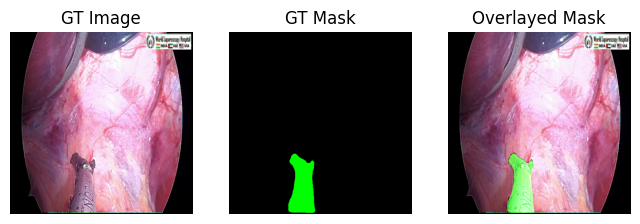

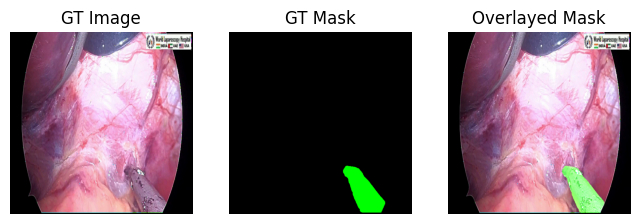

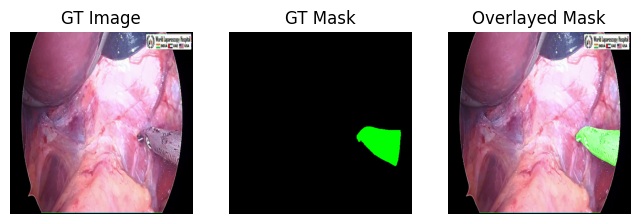

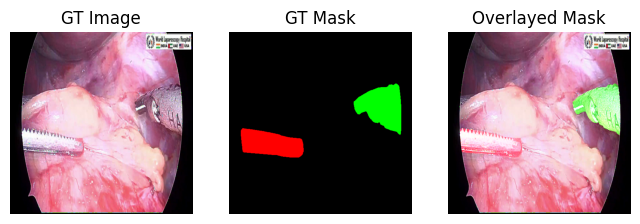

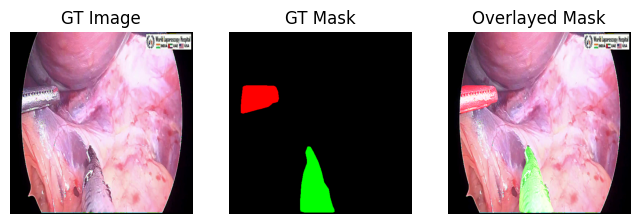

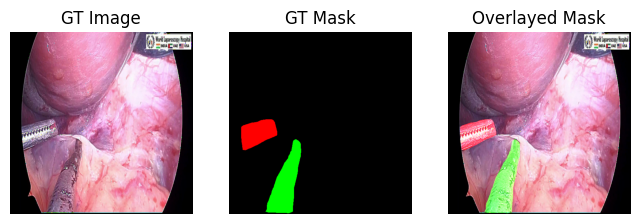

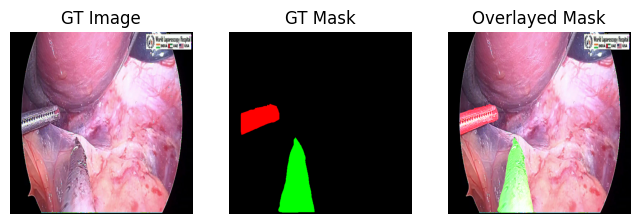

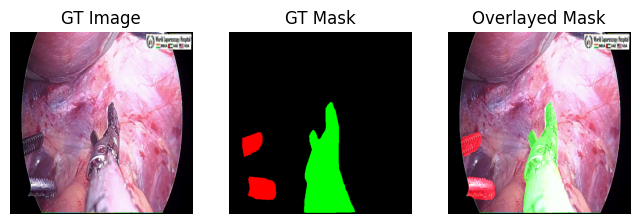

In [17]:
plot_train_ds = train_ds.map(unpackage_inputs).batch(8)
image_batch, mask_batch = next(iter(plot_train_ds.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for image, gt_mask in zip(image_batch, mask_batch):

    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask(
    [(image.numpy() * 255).astype(np.uint8), gt_mask],
    title_list=titles,
    figsize=(8,6),
    color_mask=True)

In [22]:
augment_fn = keras_cv.layers.Augmenter(
    [
        keras_cv.layers.RandomFlip(mode="horizontal"),
        keras_cv.layers.RandomBrightness(
            factor=DatasetConfig.BRIGHTNESS_FACTOR,
            value_range=(0.0, 1.0)
        ),
        keras_cv.layers.RandomContrast(
            factor=DatasetConfig.CONTRAST_FACTOR,
            value_range=(0.0, 1.0)
        ),
    ]
)

In [23]:
train_dataset = (
                train_ds.shuffle(DatasetConfig.BATCH_SIZE)
                .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(DatasetConfig.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = (
                valid_ds.batch(DatasetConfig.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [24]:
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(preset = TrainingConfig.MODEL,
                                                          input_shape=DatasetConfig.IMAGE_SIZE+(3,),
                                                          load_weights = True)
model = keras_cv.models.segmentation.DeepLabV3Plus(
        num_classes=DatasetConfig.NUM_CLASSES, backbone=backbone,
    )

model.summary()

Model: "deep_lab_v3_plus"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 128, 128, │ 20,331,360 │ input_layer[0][0] │
│ (Functional)        │ 48), (None, 16,   │            │                   │
│                     │ 16, 1280)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_pyramid_po… │ (None, 16, 16,    │  9,836,544 │ functional[0][1]  │
│ (SpatialPyramidPoo… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_output_ups… │ (None, 128, 128,  │          0 │ spatial_pyramid_… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 128, 128,  │      2,496 │ functional[0][0]  │
│ (Sequential)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ encoder_output_u… │
│ (Concatenate)       │ 304)              │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 512, 512,  │     80,640 │ concatenate[0][0] │
│ (Sequential)        │ 7)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,251,040 (115.40 MB)

 Trainable params: 30,093,488 (114.80 MB)

 Non-trainable params: 157,552 (615.44 KB)

In [25]:
# backbone = keras_cv.models.ResNet50V2Backbone.from_preset(preset = TrainingConfig.MODEL,
#                                                           input_shape=DatasetConfig.IMAGE_SIZE+(3,),
#                                                           load_weights = True)
# model = keras_cv.models.segmentation.DeepLabV3Plus(
#         num_classes=DatasetConfig.NUM_CLASSES, backbone=backbone,
#     )

# model.summary()

In [26]:
def get_callbacks(
    TrainingConfig,
    monitor="val_mean_iou",
    mode="max",
    save_weights_only=True,
    save_best_only=True,
):

    # Initialize tensorboard callback for logging.
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(
    #     log_dir=TrainingConfig.LOGS_DIR,
    #     histogram_freq=20,
    #     write_graph=False,
    #     update_freq="epoch",
    # )

    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = TrainingConfig.CKPT_DIR

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=1,
    )

    return [model_checkpoint_callback]

In [27]:
def mean_iou(y_true, y_pred):

    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    y_true = tf.squeeze(y_true, axis=-1)

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=(1, 2))

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=(1, 2)) + tf.math.reduce_sum(y_pred, axis=(1, 2))

    union = total - intersection

    iou = tf.math.divide_no_nan(intersection, union)

    iou   = iou[:, 1:]
    total = total[:, 1:]

    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    iou = tf.math.reduce_sum(iou, axis=1) / tf.maximum(num_classes_present, 1.0)

    # Compute the mean across the batch axis. Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)

    return mean_iou

In [28]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    y_true: (B, H, W, 1) integer labels
    y_pred: (B, H, W, C) softmax probabilities
    """

    # Remove channel dim
    y_true = tf.squeeze(y_true, axis=-1)

    num_classes = tf.shape(y_pred)[-1]

    # One-hot GT
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)

    # Drop background (class 0)
    y_true = y_true[..., 1:]
    y_pred = y_pred[..., 1:]

    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2))

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1.0 - tf.reduce_mean(dice)

In [29]:
def sparse_ce_with_label_smoothing(y_true, y_pred, smoothing=0.05):
    """
    y_true: (B, H, W, 1) integer labels
    y_pred: (B, H, W, C) softmax probabilities
    """

    y_true = tf.squeeze(y_true, axis=-1)
    num_classes = tf.shape(y_pred)[-1]

    # One-hot encode
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)

    # Apply label smoothing
    y_true_oh = y_true_oh * (1.0 - smoothing) + smoothing / tf.cast(num_classes, tf.float32)

    # Cross-entropy
    ce = -tf.reduce_sum(y_true_oh * tf.math.log(y_pred + 1e-7), axis=-1)

    return tf.reduce_mean(ce)

In [30]:
# ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(
#     from_logits=False
# )

# def dice_ce_loss(y_true, y_pred):
#     return ce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)

def dice_ce_loss(y_true, y_pred):
    return sparse_ce_with_label_smoothing(y_true, y_pred, smoothing=0.05) \
           + dice_loss(y_true, y_pred)

In [31]:
# Get callbacks.
callbacks = get_callbacks(TrainingConfig)
# Define Loss.
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) # softmax already in final activation layer
# Compile model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(TrainingConfig.LEARNING_RATE),
    loss=dice_ce_loss,
    metrics=["accuracy", mean_iou],
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=TrainingConfig.EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8783 - loss: 1.5727 - mean_iou: 0.0452
Epoch 1: val_mean_iou improved from -inf to 0.05184, saving model to deeplabv3_plus_SIS.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 2001s 6s/step - accuracy: 0.8785 - loss: 1.5720 - mean_iou: 0.0453 - val_accuracy: 0.9417 - val_loss: 1.2698 - val_mean_iou: 0.0518
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9363 - loss: 1.1647 - mean_iou: 0.1090
Epoch 2: val_mean_iou improved from 0.05184 to 0.09591, saving model to deeplabv3_plus_SIS.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.9363 - loss: 1.1646 - mean_iou: 0.1091 - val_accuracy: 0.9527 - val_loss: 1.1008 - val_mean_iou: 0.0959
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9448 - loss: 1.0951 - mean_iou: 0.1565
Epoch 3: val_mean_iou improved from 0.09591 to 0.18563, saving model to deeplabv3_plus_SIS.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.9448 - l

In [ ]:
history2 = model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9804 - loss: 0.8722 - mean_iou: 0.4873
Epoch 1: val_mean_iou improved from 0.38103 to 0.39464, saving model to deeplabv3_plus_SIS.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.9804 - loss: 0.8721 - mean_iou: 0.4875 - val_accuracy: 0.9782 - val_loss: 0.9236 - val_mean_iou: 0.3946
Epoch 2/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9817 - loss: 0.8628 - mean_iou: 0.5309
Epoch 2: val_mean_iou improved from 0.39464 to 0.40462, saving model to deeplabv3_plus_SIS.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - accuracy: 0.9817 - loss: 0.8628 - mean_iou: 0.5310 - val_accuracy: 0.9783 - val_loss: 0.9255 - val_mean_iou: 0.4046
Epoch 3/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9840 - loss: 0.8492 - mean_iou: 0.5634
Epoch 3: val_mean_iou improved from 0.40462 to 0.43469, saving model to deeplabv3_plus_SIS.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.9840 -

In [ ]:
history3 = model.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9924 - loss: 0.7988 - mean_iou: 0.8228
Epoch 1: val_mean_iou improved from -inf to 0.57150, saving model to deeplabv3_plus_SIS_tuned.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 2248s 6s/step - accuracy: 0.9924 - loss: 0.7988 - mean_iou: 0.8228 - val_accuracy: 0.9871 - val_loss: 0.8766 - val_mean_iou: 0.5715
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9925 - loss: 0.7978 - mean_iou: 0.8170
Epoch 2: val_mean_iou improved from 0.57150 to 0.57371, saving model to deeplabv3_plus_SIS_tuned.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.9925 - loss: 0.7978 - mean_iou: 0.8170 - val_accuracy: 0.9872 - val_loss: 0.8752 - val_mean_iou: 0.5737
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9927 - loss: 0.7970 - mean_iou: 0.8202
Epoch 3: val_mean_iou improved from 0.57371 to 0.57559, saving model to deeplabv3_plus_SIS_tuned.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - ac

In [ ]:
historyfinal = model.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9930 - loss: 1.3284 - mean_iou: 0.8323
Epoch 1: val_mean_iou improved from -inf to 0.51637, saving model to deeplabv3_plus_SIS_tuned_more.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 1495s 4s/step - accuracy: 0.9930 - loss: 1.3282 - mean_iou: 0.8322 - val_accuracy: 0.9841 - val_loss: 1.2640 - val_mean_iou: 0.5164
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9914 - loss: 1.1312 - mean_iou: 0.7581
Epoch 2: val_mean_iou did not improve from 0.51637
337/337 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.9914 - loss: 1.1311 - mean_iou: 0.7581 - val_accuracy: 0.9847 - val_loss: 1.1847 - val_mean_iou: 0.4920
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9920 - loss: 1.1060 - mean_iou: 0.7736
Epoch 3: val_mean_iou did not improve from 0.51637
337/337 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.9920 - loss: 1.1059 - mean_iou: 0.7736 - val_accuracy: 0.9850 - val_loss: 1.1696 - val_mean_iou: 0.

In [ ]:
historyfinal2 = model.fit(
    train_dataset,
    epochs=5,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9925 - loss: 1.0859 - mean_iou: 0.8244
Epoch 1: val_mean_iou improved from -inf to 0.55995, saving model to deeplabv3_plus_SIS_tuned_more.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 526s 1s/step - accuracy: 0.9925 - loss: 1.0858 - mean_iou: 0.8245 - val_accuracy: 0.9863 - val_loss: 1.1524 - val_mean_iou: 0.5600
Epoch 2/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9928 - loss: 1.0847 - mean_iou: 0.8242
Epoch 2: val_mean_iou improved from 0.55995 to 0.56525, saving model to deeplabv3_plus_SIS_tuned_more.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.9928 - loss: 1.0846 - mean_iou: 0.8242 - val_accuracy: 0.9862 - val_loss: 1.1526 - val_mean_iou: 0.5653
Epoch 3/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9927 - loss: 1.0843 - mean_iou: 0.8271
Epoch 3: val_mean_iou did not improve from 0.56525
337/337 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.9927 - loss: 1.0843 - mean_iou: 0.8271 - 

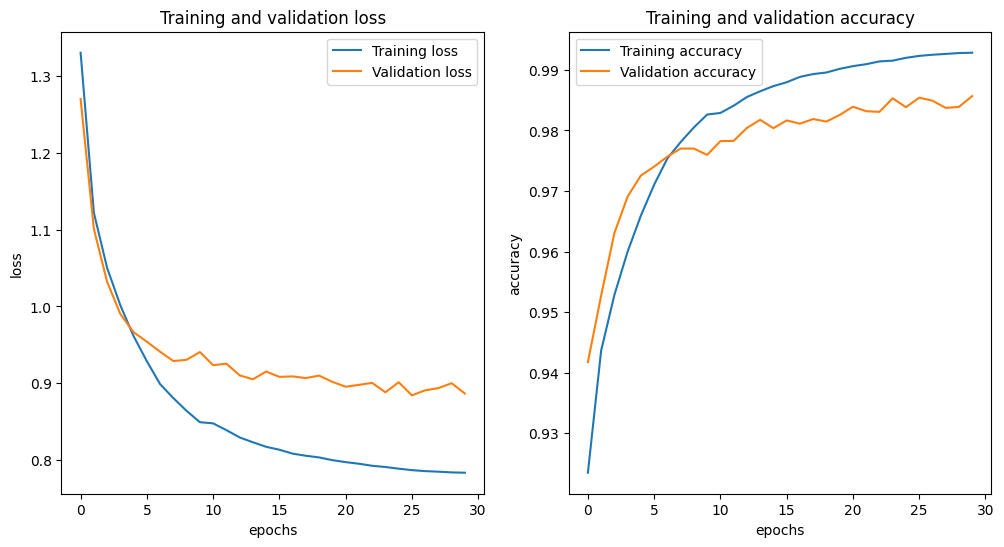

In [ ]:
'''Plots the training and validation loss and accuracy from a history object'''
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

loss += history2.history['loss']
val_loss += history2.history['val_loss']
accuracy += history2.history['accuracy']
val_accuracy += history2.history['val_accuracy']

epochs = range(len(loss))

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(epochs, loss, label='Training loss')
ax[0].plot(epochs, val_loss, label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(epochs, accuracy, label='Training accuracy')
ax[1].plot(epochs, val_accuracy, label='Validation accuracy')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend()

plt.show()

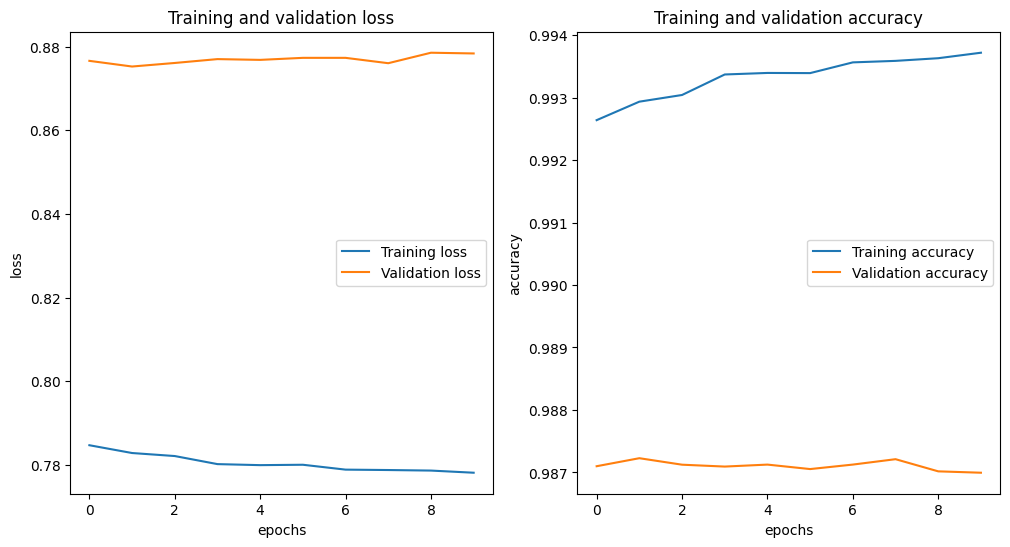

In [ ]:
'''Plots the training and validation loss and accuracy from a history object'''
loss = history3.history['loss']
val_loss = history3.history['val_loss']
accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']

epochs = range(len(loss))

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(epochs, loss, label='Training loss')
ax[0].plot(epochs, val_loss, label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(epochs, accuracy, label='Training accuracy')
ax[1].plot(epochs, val_accuracy, label='Validation accuracy')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend()

plt.show()

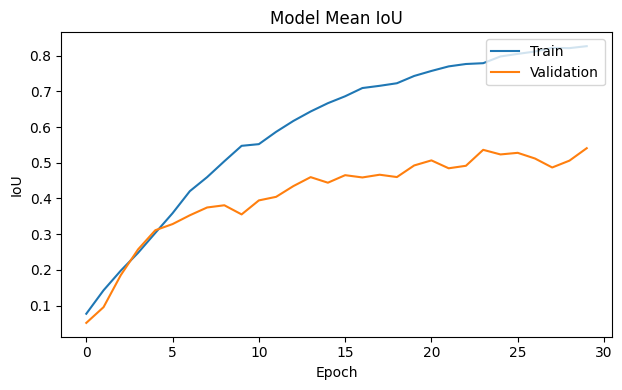

In [ ]:
# meaniou = history.history['mean_iou']
# val_meaniou = history.history['val_mean_iou']

meaniou += history2.history['mean_iou']
val_meaniou += history2.history['val_mean_iou']

plt.figure(figsize=(12, 4))
# Plot training & validation mean iou values
plt.subplot(1, 2, 2)
plt.plot(meaniou)
plt.plot(val_meaniou)
plt.title('Model Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

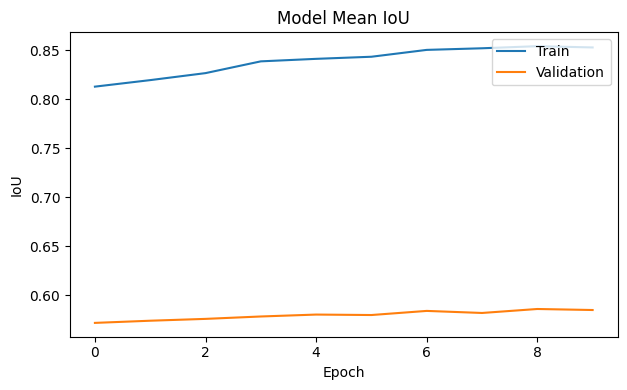

In [ ]:
meaniou = history3.history['mean_iou']
val_meaniou = history3.history['val_mean_iou']
plt.figure(figsize=(12, 4))
# Plot training & validation mean iou values
plt.subplot(1, 2, 2)
plt.plot(meaniou)
plt.plot(val_meaniou)
plt.title('Model Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

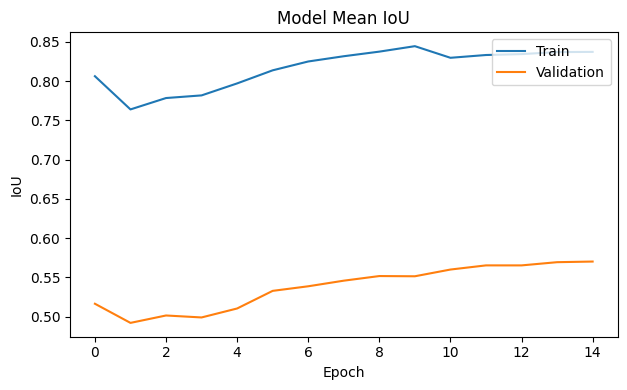

In [ ]:
# meaniou = historyfinal.history['mean_iou']
# val_meaniou = historyfinal.history['val_mean_iou']

meaniou += historyfinal2.history['mean_iou']
val_meaniou += historyfinal2.history['val_mean_iou']
plt.figure(figsize=(12, 4))
# Plot training & validation mean iou values
plt.subplot(1, 2, 2)
plt.plot(meaniou)
plt.plot(val_meaniou)
plt.title('Model Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [33]:
model.load_weights('deeplabv3_plus_SIS_tuned_more.weights.h5')

In [34]:
def display_image_and_mask(data_list, axes, title_list, color_mask=False, color_map=id2color):

    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask

    if len(data_list) == 3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask

    overlayed_image = image_overlay(data_list[0], mask_to_overlay)
    data_list.append(overlayed_image)

    for idx, axis in enumerate(axes):
        axis.set_title(title_list[idx])

        if title_list[idx] == "GT Mask":
            axis.imshow(rgb_gt_mask if color_mask else data_list[1])

        elif title_list[idx] == "Pred Mask":
            axis.imshow(rgb_pred_mask if color_mask else data_list[-1])

        else:
            axis.imshow(data_list[idx])

        axis.axis("off")

In [35]:
def inference(model, dataset, samples_to_plot):

    titles = ["Image", "GT Mask", "Pred Mask", "Overlayed Prediction"]

    fig, axes = plt.subplots(
        nrows=samples_to_plot,
        ncols=4,
        figsize=(20, 5 * samples_to_plot)
    )

    row = 0

    for data in dataset:
        batch_img, batch_mask = data

        # batch_pred = model.predict(batch_img)
        # pred = batch_pred.argmax(axis=-1)

        probs = model.predict(batch_img, verbose=0)
        top2 = np.partition(probs, -2, axis=-1)[..., -2:]
        conf_gap = top2[..., 1] - top2[..., 0]

        pred = np.argmax(probs, axis=-1)
        pred[conf_gap < 0.1] = 0

        batch_img  = (batch_img.numpy() * 255).astype(np.uint8)
        batch_mask = batch_mask.numpy().squeeze(-1)

        for image, mask, pr in zip(batch_img, batch_mask, pred):

            display_image_and_mask(
                [image, mask, pr],
                axes=axes[row],
                title_list=titles,
                color_mask=True
            )

            row += 1
            if row >= samples_to_plot:
                plt.tight_layout()
                plt.show()
                return

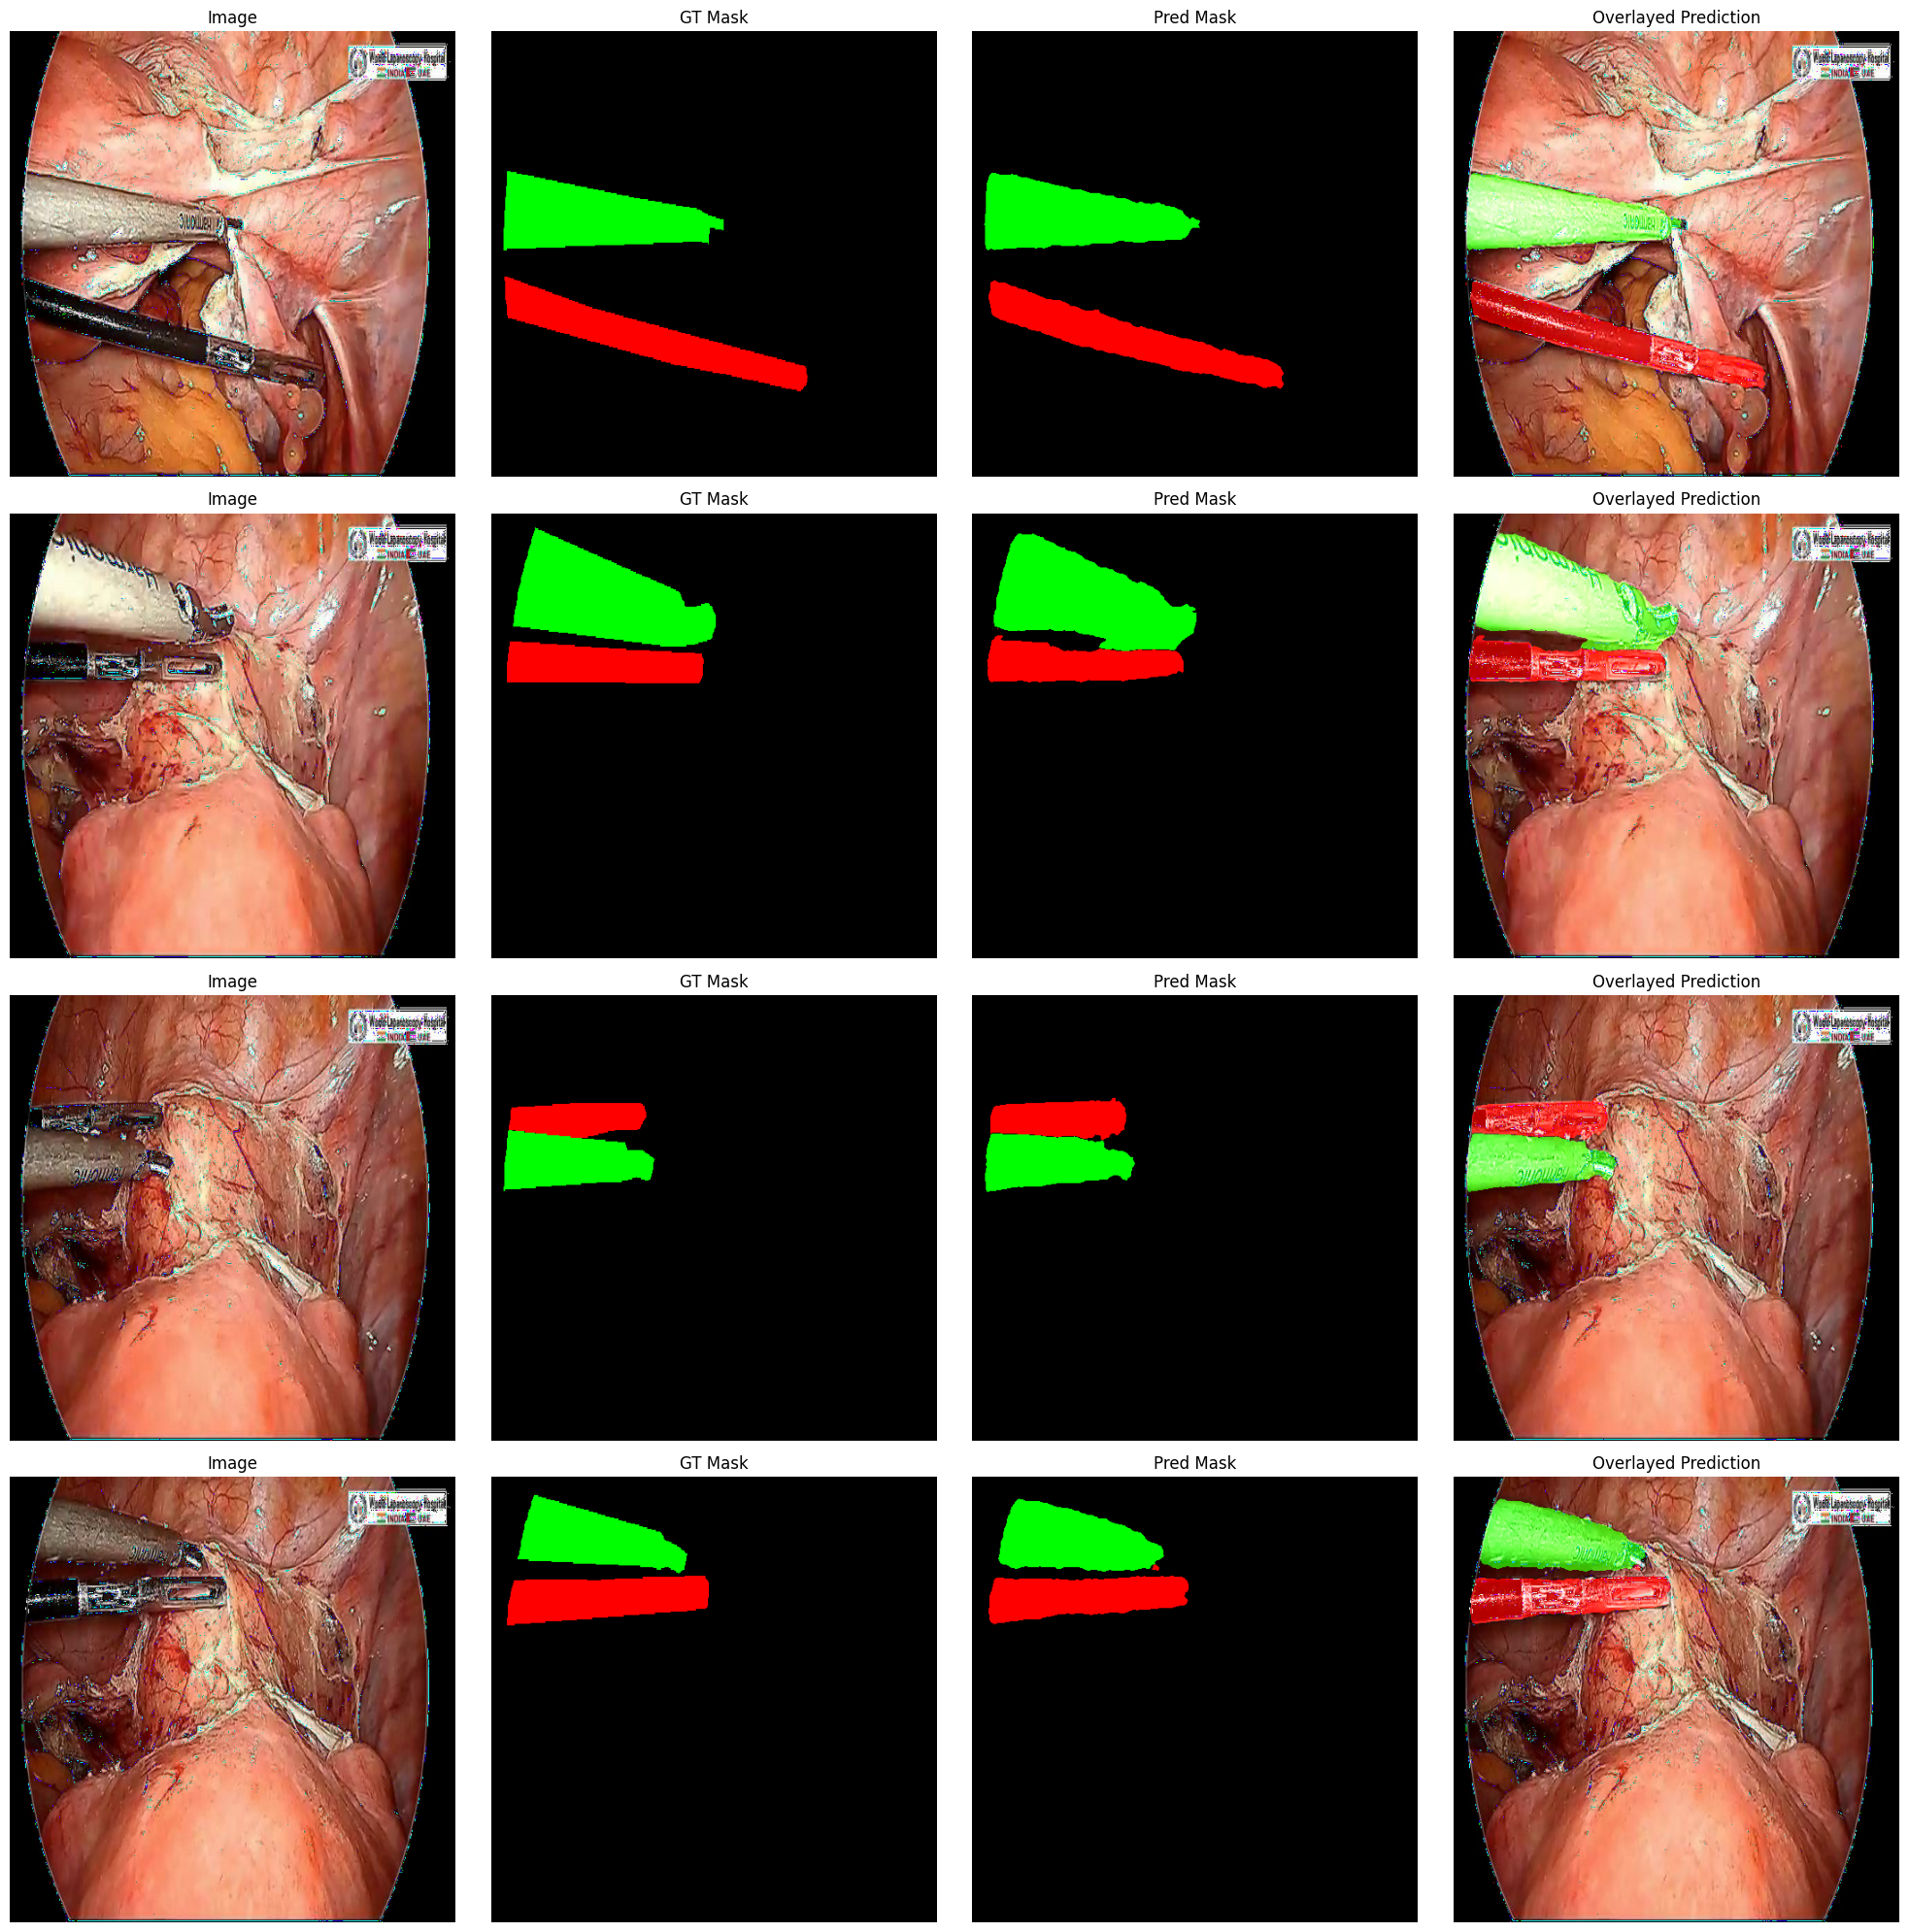

In [36]:
# inference(model, valid_dataset.shuffle(80), 50)
inference(model, valid_dataset.shuffle(8), 4)

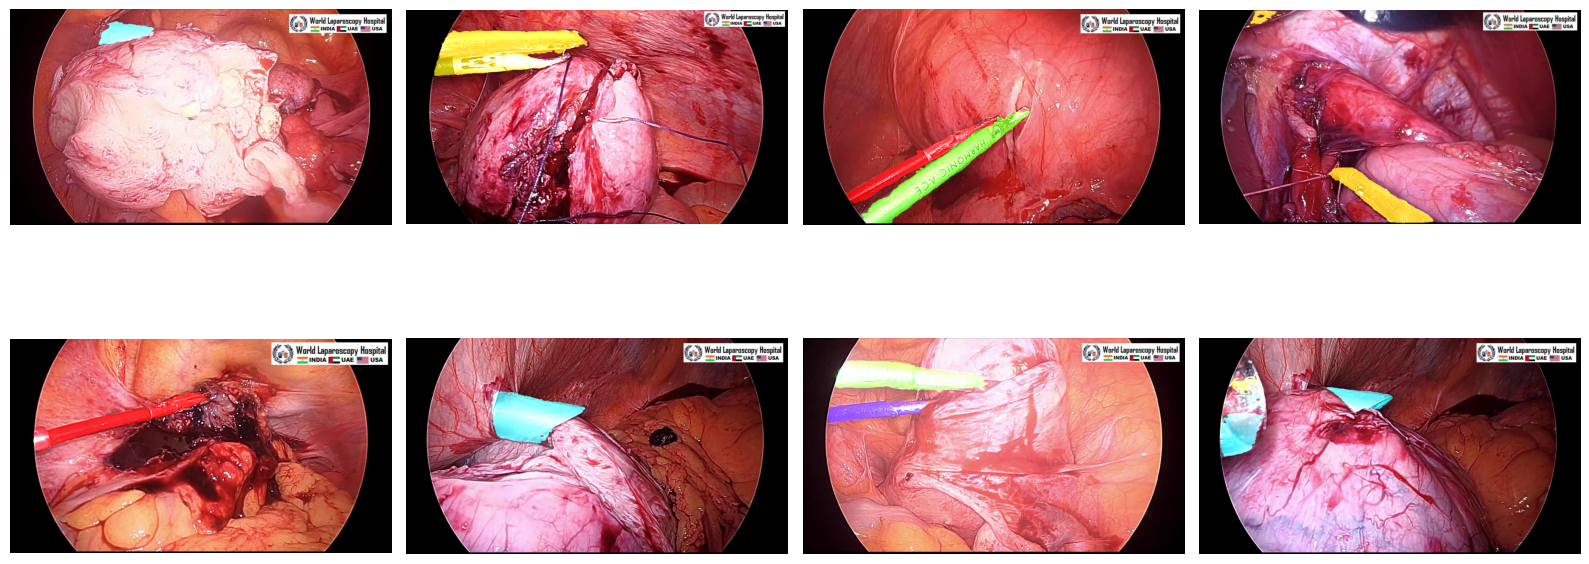

In [48]:
import os, random, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
val_dir = "/content/gdrive/MyDrive/Tensorflow-Models/datasets/surgical_instruments/images/valid"

N = 8
cols = 4
rows = int(np.ceil(N / cols))
CONF_GAP = 0.1
INPUT_SIZE = (512, 512)
# ----------------------------------------

# collect images
all_imgs = [
    os.path.join(val_dir, f)
    for f in os.listdir(val_dir)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

sample_imgs = random.sample(all_imgs, N)

# ---------------- LOAD IMAGES ----------------
orig_images = []
model_images = []
orig_sizes = []

for p in sample_imgs:
    img_bgr = cv2.imread(p)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    h, w = img_rgb.shape[:2]
    orig_sizes.append((h, w))
    orig_images.append(img_rgb)

    img_resized = cv2.resize(img_rgb, INPUT_SIZE, interpolation=cv2.INTER_LINEAR)
    model_images.append(img_resized.astype(np.float32) / 255.0)

model_images = np.array(model_images)

# ---------------- INFERENCE ----------------
probs = model.predict(model_images, verbose=0)

top2 = np.partition(probs, -2, axis=-1)[..., -2:]
conf_gap = top2[..., 1] - top2[..., 0]

pred = np.argmax(probs, axis=-1)
pred[conf_gap < CONF_GAP] = 0

# ---------------- VISUALIZATION ----------------
plt.figure(figsize=(4 * cols, 4 * rows))

for i, (img, pr, (h, w)) in enumerate(zip(orig_images, pred, orig_sizes)):
    # resize prediction back to original image size
    pr_resized = cv2.resize(
        pr.astype(np.uint8),
        (w, h),
        interpolation=cv2.INTER_NEAREST
    )

    rgb_pred = num_to_rgb(pr_resized, color_map=id2color)
    overlay = image_overlay(img, rgb_pred)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(overlay)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Serialize the model as a SavedModel.
# Use model.export for Keras models
model.export("deeplabv3_plus_SIS")

# Convert to TFLite. This form of quantization is called
# post-training dynamic-range quantization in TFLite.
converter = tf.lite.TFLiteConverter.from_saved_model("deeplabv3_plus_SIS")

# Enable TF Select ops for unsupported operations
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS # Enable TF Select ops
]

# No optimizations
tflite_model = converter.convert()
open("deeplabv3_plus_SIS.tflite", "wb").write(tflite_model)

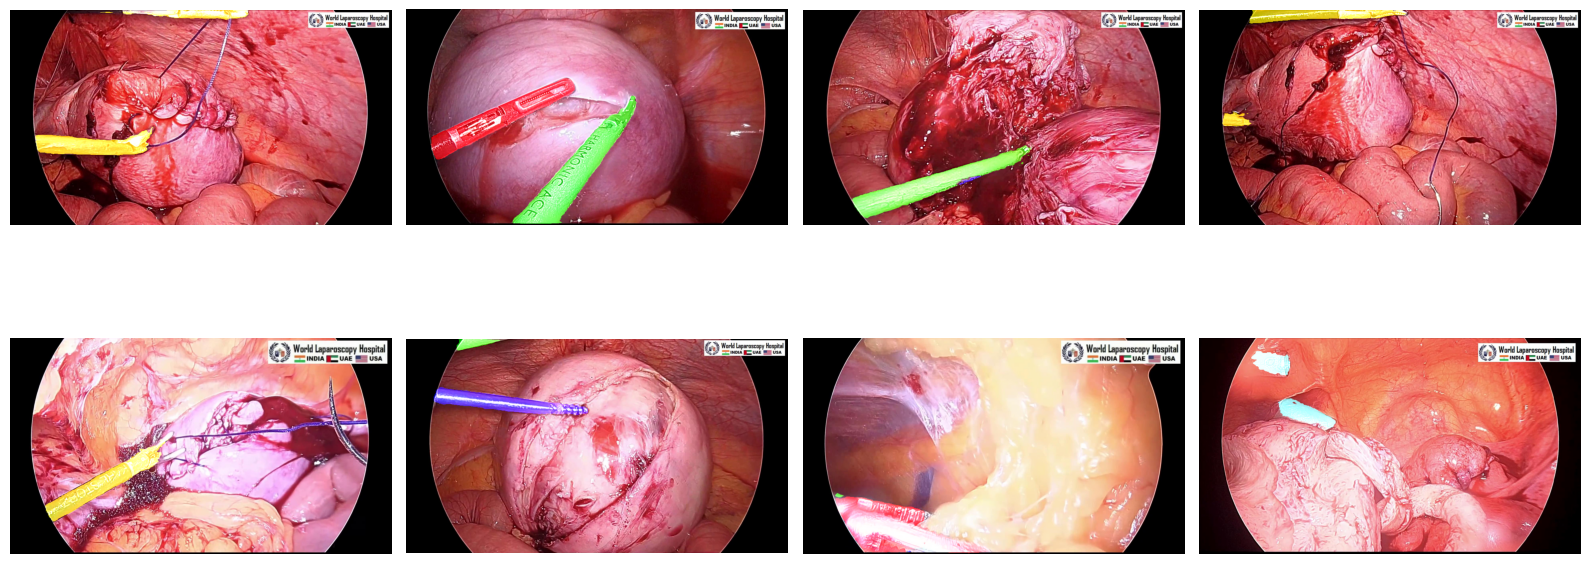

In [52]:
import os, random, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
val_dir = "/content/gdrive/MyDrive/Tensorflow-Models/datasets/surgical_instruments/images/valid"

N = 8
cols = 4
rows = int(np.ceil(N / cols))
CONF_GAP = 0.1
INPUT_SIZE = (512, 512)
# ----------------------------------------

# ---------- LOAD TFLITE ----------
interpreter = tf.lite.Interpreter(
    model_path="deeplabv3_plus_SIS.tflite"
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# ---- FIX MODEL INPUT SHAPE (ONCE) ----
MODEL_H = 512   # MUST match training
MODEL_W = 512

interpreter.resize_tensor_input(
    input_details[0]["index"],
    [1, MODEL_H, MODEL_W, 3],
    strict=True
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# collect images
all_imgs = [
    os.path.join(val_dir, f)
    for f in os.listdir(val_dir)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

sample_imgs = random.sample(all_imgs, N)

# ---------------- LOAD IMAGES ----------------
orig_images = []
model_images = []
orig_sizes = []

for p in sample_imgs:
    img_bgr = cv2.imread(p)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    h, w = img_rgb.shape[:2]
    orig_sizes.append((h, w))
    orig_images.append(img_rgb)

    img_resized = cv2.resize(img_rgb, INPUT_SIZE, interpolation=cv2.INTER_LINEAR)
    model_images.append(img_resized.astype(np.float32) / 255.0)

model_images = np.array(model_images)

# ---------------- INFERENCE (TFLITE, SINGLE IMAGE) ----------------
all_preds = []

for img in model_images:
    # add batch dimension
    input_tensor = np.expand_dims(img, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]["index"], input_tensor)
    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]["index"])  # (1, 512, 512, C)
    all_preds.append(output[0])  # remove batch dim

probs = np.array(all_preds)  # (N, 512, 512, C)

top2 = np.partition(probs, -2, axis=-1)[..., -2:]
conf_gap = top2[..., 1] - top2[..., 0]

pred = np.argmax(probs, axis=-1)
pred[conf_gap < CONF_GAP] = 0

# ---------------- VISUALIZATION ----------------
plt.figure(figsize=(4 * cols, 4 * rows))

for i, (img, pr, (h, w)) in enumerate(zip(orig_images, pred, orig_sizes)):
    # resize prediction back to original image size
    pr_resized = cv2.resize(
        pr.astype(np.uint8),
        (w, h),
        interpolation=cv2.INTER_NEAREST
    )

    rgb_pred = num_to_rgb(pr_resized, color_map=id2color)
    overlay = image_overlay(img, rgb_pred)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(overlay)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
!pip install tf2onnx onnx onnxruntime

In [33]:
import tf2onnx
import tensorflow as tf

# 1. Define the input signature
spec = (tf.TensorSpec((None, 512, 512, 3), tf.float32, name="input"),)

# 2. Convert the model
output_path = "deeplabv3_plus_SIS.onnx"

model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=13, # Standard version for compatibility
    output_path=output_path
)

print(f"SUCCESS! Your model is saved as {output_path}")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7cb135960d60>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


SUCCESS! Your model is saved as deeplabv3_plus_SIS.onnx


In [8]:
import onnxruntime as ort
import numpy as np

session = ort.InferenceSession("deeplabv3_plus_SIS.onnx")
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

dummy_input = np.random.rand(1, 512, 512, 3).astype(np.float32)

outputs = session.run(None, {input_name: dummy_input})

print(len(outputs))
for o in outputs:
    print(o.shape)

1
(1, 512, 512, 7)


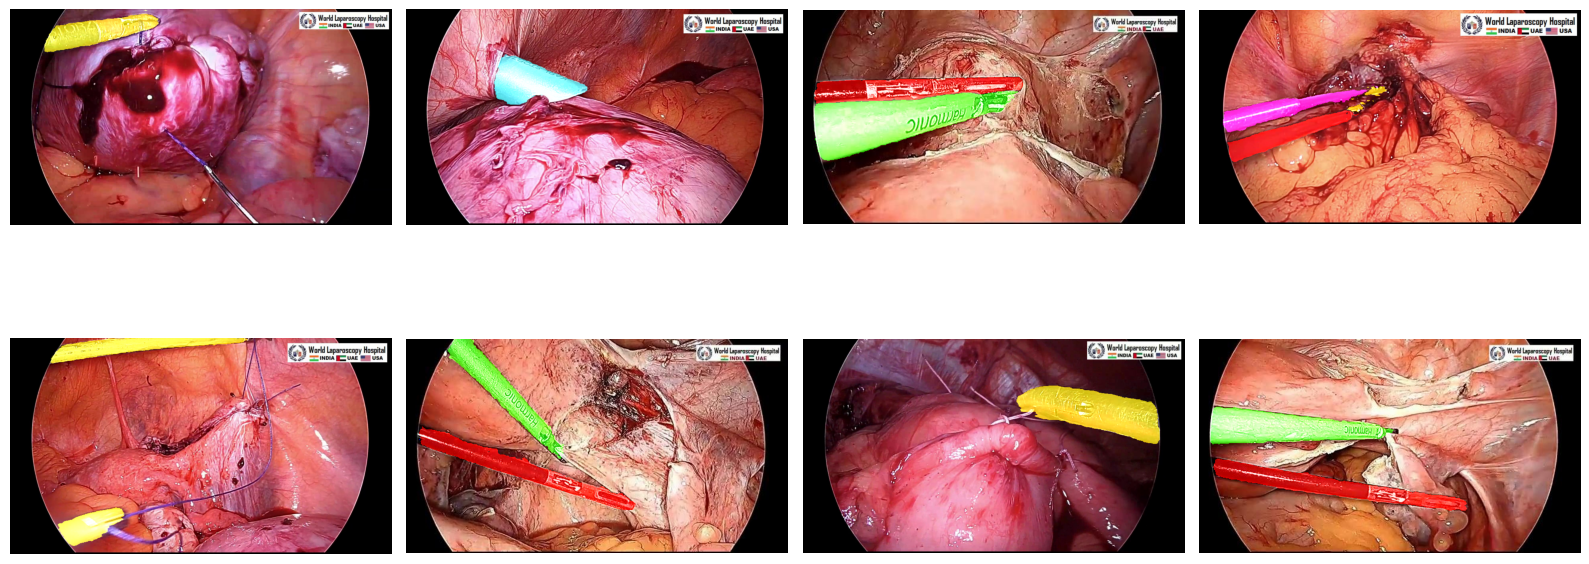

In [17]:
import os, random, cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
val_dir = "/content/gdrive/MyDrive/Tensorflow-Models/datasets/surgical_instruments/images/valid"

N = 8
cols = 4
rows = int(np.ceil(N / cols))
CONF_GAP = 0.1
INPUT_SIZE = (512, 512)
# ----------------------------------------

# ---------- LOAD ONNX ----------
session = ort.InferenceSession("deeplabv3_plus_SIS.onnx")
input_name  = session.get_inputs()[0].name
output_names = [output.name for output in session.get_outputs()]

# collect images
all_imgs = [
    os.path.join(val_dir, f)
    for f in os.listdir(val_dir)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

sample_imgs = random.sample(all_imgs, N)

# ---------------- LOAD IMAGES ----------------
orig_images = []
model_images = []
orig_sizes = []

for p in sample_imgs:
    img_bgr = cv2.imread(p)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    h, w = img_rgb.shape[:2]
    orig_sizes.append((h, w))
    orig_images.append(img_rgb)

    img_resized = cv2.resize(img_rgb, INPUT_SIZE, interpolation=cv2.INTER_LINEAR)
    model_images.append(img_resized.astype(np.float32) / 255.0)

model_images = np.array(model_images)

# ---------- RUN ONNX INFERENCE ----------
preds = []

for img in model_images:
    input_tensor = np.expand_dims(img, axis=0).astype(np.float32)

    probs = session.run(
        output_names,
        {input_name: input_tensor}
    )[0][0]  # (512, 512, C)

    # confidence gap (IMMEDIATELY)
    top2 = np.partition(probs, -2, axis=-1)[..., -2:]
    conf_gap = top2[..., 1] - top2[..., 0]

    pred = np.argmax(probs, axis=-1)
    pred[conf_gap < CONF_GAP] = 0

    preds.append(pred.astype(np.uint8))

    # IMPORTANT: free memory explicitly
    del probs, top2, conf_gap

pred = np.array(preds)  # (N, 512, 512)

# ---------------- VISUALIZATION ----------------
plt.figure(figsize=(4 * cols, 4 * rows))

for i, (img, pr, (h, w)) in enumerate(zip(orig_images, pred, orig_sizes)):
    # resize prediction back to original image size
    pr_resized = cv2.resize(
        pr.astype(np.uint8),
        (w, h),
        interpolation=cv2.INTER_NEAREST
    )

    rgb_pred = num_to_rgb(pr_resized, color_map=id2color)
    overlay = image_overlay(img, rgb_pred)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(overlay)
    plt.axis("off")

plt.tight_layout()
plt.show()